In [2]:
# Import python packages that are used here
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, glob
import cmath as cm
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
from glob import glob
from matplotlib.pyplot import figure
import os
import sys


# Import `functions.py` to help us to import measured data
from functions import import_pol_data
from functions import import_lin_data
from functions import import_TD_data
from functions import Do_the_thing

In [3]:
# Change the path here to the folder that contains the data
root_path = r'/Users/itungchen/UW_lab_data/'
DL_dir_name =  root_path + '/20230426-SOS-acoustic-rings//'

# Define the sort function of the frequency domain data
def sortKeyFunc_FD(s):
    return int(os.path.basename(s)[4:5])

file_name = ['35K-*-S11-1um-wg-pol.prn', '35K-*-S12-1um-wg-pol.prn', '35K-*-S21-1um-wg-pol.prn', '35K-*-S22-1um-wg-pol.prn']

# Grab file name and store in DL list
DL_4K_S11 = glob(DL_dir_name + file_name[0])
DL_4K_S11.sort(key = sortKeyFunc_FD)
DL_4K_S22 = glob(DL_dir_name + file_name[3])
DL_4K_S22.sort(key = sortKeyFunc_FD)
DL_4K_S12 = glob(DL_dir_name + file_name[1])
DL_4K_S12.sort(key = sortKeyFunc_FD)
DL_4K_S21 = glob(DL_dir_name + file_name[2])
DL_4K_S21.sort(key = sortKeyFunc_FD)

# Import frequency domain data
S11_list_4K = []
S22_list_4K = []
S12_list_4K = []
S21_list_4K = []

for fn_11, fn_12, fn_21, fn_22 in zip(DL_4K_S11, DL_4K_S12, DL_4K_S21, DL_4K_S22):
    freq11, r11, i11 = import_pol_data(fn_11)
    freq12, r12, i12 = import_pol_data(fn_12)
    freq21, r21, i21 = import_pol_data(fn_21)
    freq22, r22, i22 = import_pol_data(fn_22)
    
    S11_list_4K.append(r11 + 1j*i11)
    S12_list_4K.append(r12 + 1j*i12)
    S21_list_4K.append(r21 + 1j*i21)
    S22_list_4K.append(r22 + 1j*i22)
    

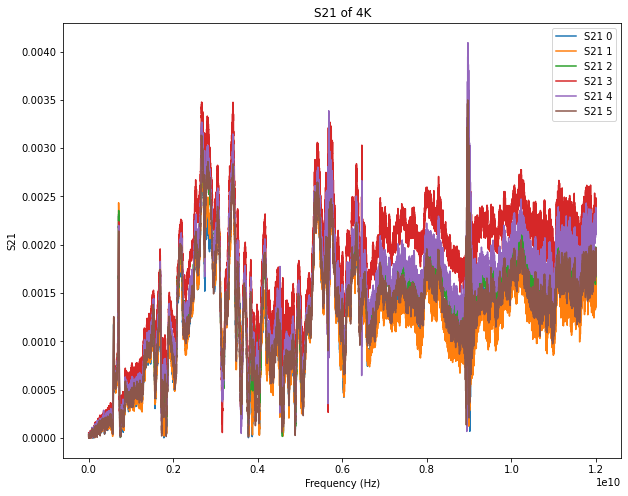

In [4]:
# Plot all the S21 data in 4K in one plot
fig, ax = plt.subplots(1,1, figsize=(10, 8))
for i in range(len(S21_list_4K)):
    ax.plot(freq21, np.abs(S21_list_4K[i]), label = 'S21 ' + str(i))
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('S21')
ax.set_title('S21 of 4K')
ax.legend()


# Fourier transform
The S21 data and plot the time domain data.

        L_delay = [30, 45, 70, 100, 140, 650, 950, 1400, 2000, 3020, 4300, 4600] # in um
        T_list = [4, 7, 13.9, 30, 40, 60, 95, 140, 210, 300]




In [5]:
import scipy.fft

def ifft_complex_data(cmpl_s21, freq, print_time_reso = True):
    # import the data
    N_pts = len(cmpl_s21)

    # Perform ifft on the imported data
    s21_ift = scipy.fft.ifft(cmpl_s21)

    # Calculate the time resolution
    t_reso = 1/((freq[-1]-freq[0]))
    
    if print_time_reso:
        print('Time resolution is:', t_reso, 'nano sec')

    # The time here inclued the flipped data
    t_span = np.array(range(N_pts))*t_reso #s

    return N_pts, s21_ift, t_span, t_reso

In [6]:
ifft_list_4K = []
for cmpl_s21 in S21_list_4K:
    N_pts, s21_ift, t_span, t_reso = ifft_complex_data(cmpl_s21, freq21, print_time_reso = False)
    ifft_list_4K.append(s21_ift)


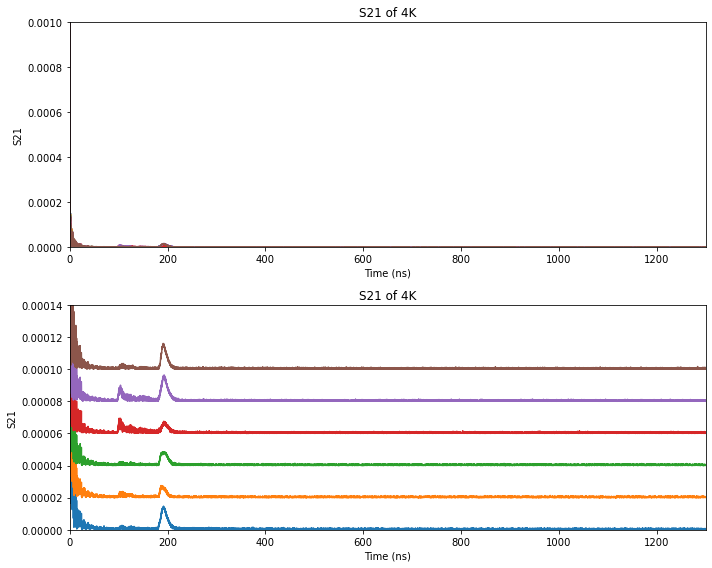

In [7]:
# Plot two plots: one is the time domain with a larger time span, the other is the time domain with a smaller time span and smaller y limit
fig, ax = plt.subplots(2,1, figsize=(10, 8))
for i in range(len(ifft_list_4K)):
    ax[0].plot(t_span/1e-9, np.abs(ifft_list_4K[i]), label = 'S21 ' + str(i))
    ax[1].plot(t_span/1e-9, np.abs(ifft_list_4K[i]) + 2e-5*i, label = 'S21 ' + str(i))

ax[0].set_xlabel('Time (ns)')
ax[0].set_ylabel('S21')
ax[0].set_title('S21 of 4K')
ax[0].set_xlim(0, 1300)
ax[0].set_ylim(0, 0.001)
#ax[0].legend()

ax[1].set_xlabel('Time (ns)')
ax[1].set_ylabel('S21')
ax[1].set_title('S21 of 4K')
#ax[1].legend()
ax[1].set_xlim(0, 1300)
ax[1].set_ylim(0, 0.00014)

plt.tight_layout()

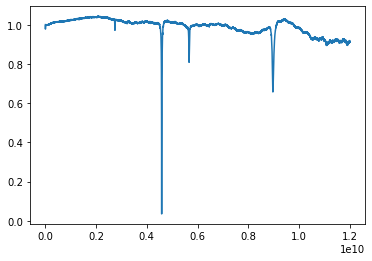

In [8]:
plt.plot(freq21, np.abs(S11_list_4K[1]), label = 'S21 ' + str(i))


# Time Gating
This is the list that stores the ifft data, and the time span of the data.

        ifft_list_4K, t_span

Now we will try to time gate the data and trasform back to look at the S21 in frequenct domain using the function 

        Filter_S21_singnals

In [9]:
from S21Gating import Filter_S21_signals

time_gated_FD_list_4K = []
for ifft_data in ifft_list_4K:
    _, nor_cmpl_filtered, t_span, ift_data, org_ift_data = Filter_S21_signals(   freq21, 
                                                                                    ifft_data, 
                                                                                    t_reso,   
                                                                                    N_pts = N_pts,  
                                                                                    filter_noise = True,
                                                                                    filter_peaks = False,
                                                                                    filter_picking = False, 
                                                                                    filter_stop = True,
                                                                                    t_noise=[150], expand_noise = 0.1,
                                                                                    t_peaks=[0], expand_peaks = 200,
                                                                                    t_picked = [0], expand_picked = 20,
                                                                                    t_stop = 500,
                                                                                    xmax=1000, ymax=1000e-8, ymax_fdom = 3e-5, manual_scale= False,
                                                                                    savefig = False,
                                                                                    plot_filtering = False)

    time_gated_FD_list_4K.append(nor_cmpl_filtered)

Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...


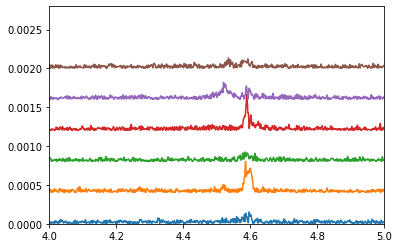

In [10]:
for i, time_gated_data in enumerate(time_gated_FD_list_4K):
    plt.plot(freq21/1e9, np.abs(time_gated_data)+ i*4e-4)

plt.xlim(4, 5)
plt.ylim(0,2.8e-3)

# Set plt size 
plt.rcParams['figure.figsize'] = [10, 8]

In [11]:
def import_ring_data(root_path, dir_name, file_name, sort_indx):
    # Change the path here to the folder that contains the data
    DL_dir_name =  root_path + dir_name

    # Define the sort function of the frequency domain data
    def sortKeyFunc_FD(s):
        return int(os.path.basename(s)[sort_indx[0]:sort_indx[1]])

    # Grab file name and store in DL list
    DL_4K_S11 = glob(DL_dir_name + file_name[0])
    DL_4K_S11.sort(key = sortKeyFunc_FD)
    DL_4K_S22 = glob(DL_dir_name + file_name[3])
    DL_4K_S22.sort(key = sortKeyFunc_FD)
    DL_4K_S12 = glob(DL_dir_name + file_name[1])
    DL_4K_S12.sort(key = sortKeyFunc_FD)
    DL_4K_S21 = glob(DL_dir_name + file_name[2])
    DL_4K_S21.sort(key = sortKeyFunc_FD)

    # Import frequency domain data
    S11_list_4K = []
    S22_list_4K = []
    S12_list_4K = []
    S21_list_4K = []

    for fn_11, fn_12, fn_21, fn_22 in zip(DL_4K_S11, DL_4K_S12, DL_4K_S21, DL_4K_S22):
        freq11, r11, i11 = import_pol_data(fn_11)
        freq12, r12, i12 = import_pol_data(fn_12)
        freq21, r21, i21 = import_pol_data(fn_21)
        freq22, r22, i22 = import_pol_data(fn_22)
        
        S11_list_4K.append(r11 + 1j*i11)
        S12_list_4K.append(r12 + 1j*i12)
        S21_list_4K.append(r21 + 1j*i21)
        S22_list_4K.append(r22 + 1j*i22)
    
    return freq11, S11_list_4K, S22_list_4K, S12_list_4K, S21_list_4K
        

In [12]:
root_path = r'/Users/itungchen/UW_lab_data/'
dir_name = '/20230515-sos-acoring-drycham//' 
file_name = ['30K-*-S11-1um-wg-pol.prn', '30K-*-S12-1um-wg-pol.prn', '30K-*-S21-1um-wg-pol.prn', '30K-*-S22-1um-wg-pol.prn']
sort_indx = [4,5]
freq, S11_list_4K, S22_list_4K, S12_list_4K, S21_list_4K = import_ring_data(root_path, dir_name, file_name, sort_indx)

In [13]:
ifft_list_4K = []
for cmpl_s21 in S21_list_4K:
    N_pts, s21_ift, t_span, t_reso = ifft_complex_data(cmpl_s21, freq, print_time_reso = True)
    ifft_list_4K.append(s21_ift)

Time resolution is: 1.4285714285714285e-10 nano sec
Time resolution is: 1.4285714285714285e-10 nano sec
Time resolution is: 1.4285714285714285e-10 nano sec
Time resolution is: 1.4285714285714285e-10 nano sec
Time resolution is: 1.4285714285714285e-10 nano sec
Time resolution is: 1.4285714285714285e-10 nano sec


* S21 at 30K.  

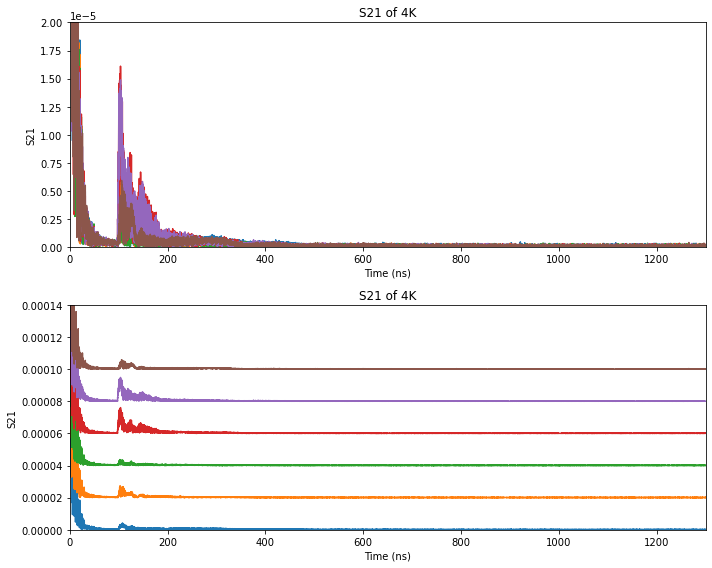

In [14]:
# Plot two plots: one is the time domain with a larger time span, the other is the time domain with a smaller time span and smaller y limit
fig, ax = plt.subplots(2,1, figsize=(10, 8))
for i in range(len(ifft_list_4K)):
    ax[0].plot(t_span/1e-9, np.abs(ifft_list_4K[i]), label = 'S21 ' + str(i))
    ax[1].plot(t_span/1e-9, np.abs(ifft_list_4K[i]) + 2e-5*i, label = 'S21 ' + str(i))

ax[0].set_xlabel('Time (ns)')
ax[0].set_ylabel('S21')
ax[0].set_title('S21 of 4K')
ax[0].set_xlim(0, 1300)
ax[0].set_ylim(0, 2e-5)
#ax[0].legend()

ax[1].set_xlabel('Time (ns)')
ax[1].set_ylabel('S21')
ax[1].set_title('S21 of 4K')
#ax[1].legend()
ax[1].set_xlim(0, 1300)
ax[1].set_ylim(0, 0.00014)

plt.tight_layout()

Acoustic velocity 650um/100ns = 6500 m/s 

Acoustic ring total length (race track ring, diameter 100um racetrack 25um) = 346um

In [15]:
v_Ac = 650e3/100
L_ring = np.pi*100 + 50
L_wg = 589
print('acoustic velocity = ', v_Ac, 'm/s' )
print('Ring length= ', np.pi*100 + 50, 'um')
print('through waveguide length= ', 589, 'um') 

print('arrivial time = ', L_wg/v_Ac*1e3, 'ns')
print('Ring time = ', L_ring/v_Ac*1e3, 'ns')

acoustic velocity =  6500.0 m/s
Ring length=  364.1592653589793 um
through waveguide length=  589 um
arrivial time =  90.61538461538461 ns
Ring time =  56.0245023629199 ns


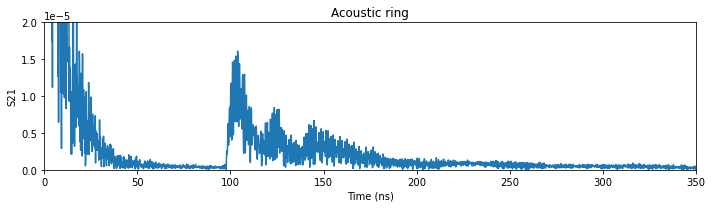

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10, 3))

ax.plot(t_span/1e-9, np.abs(ifft_list_4K[3]), label = 'S21 ' + str(i))

ax.set_xlabel('Time (ns)')
ax.set_ylabel('S21')
ax.set_title('Acoustic ring')
ax.set_xlim(0, 350)
ax.set_ylim(0, 2e-5)
#ax[0].legend()

plt.tight_layout()

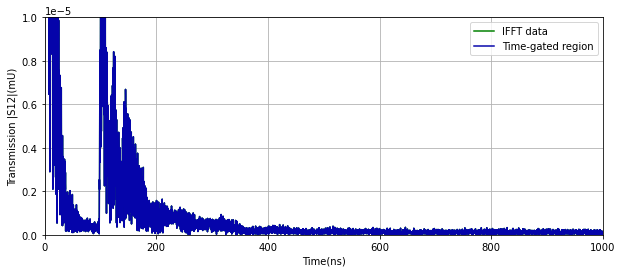

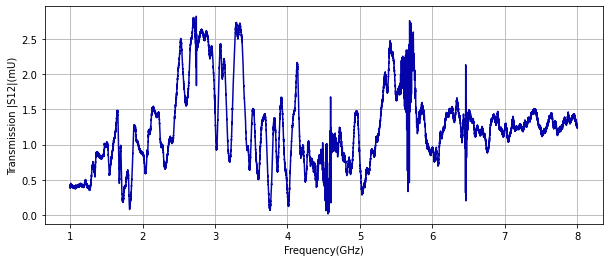

In [17]:
_, nor_cmpl_filtered, t_span, ift_data, org_ift_data = Filter_S21_signals(   freq, 
                                                                                ifft_list_4K[3], 
                                                                                t_reso,   
                                                                                N_pts = N_pts,  
                                                                                filter_noise = False,
                                                                                filter_peaks = False,
                                                                                filter_picking = False, 
                                                                                filter_stop = False,
                                                                                t_noise=[60], expand_noise = 0.1,
                                                                                t_peaks=[110], expand_peaks = 25,
                                                                                t_picked = [0], expand_picked = 20,
                                                                                t_stop = 500,
                                                                                xmax=1000, ymax=1000e-8, ymax_fdom = 3e-5, manual_scale= False,
                                                                                savefig = False,
                                                                                plot_filtering = True)

Filtering(1) noise...
Filtering(2) peaks...
Filtering(1) noise...
Filtering(2) peaks...
Filtering(1) noise...
Filtering(2) peaks...
Filtering(1) noise...
Filtering(2) peaks...
Filtering(1) noise...
Filtering(2) peaks...
Filtering(1) noise...
Filtering(2) peaks...


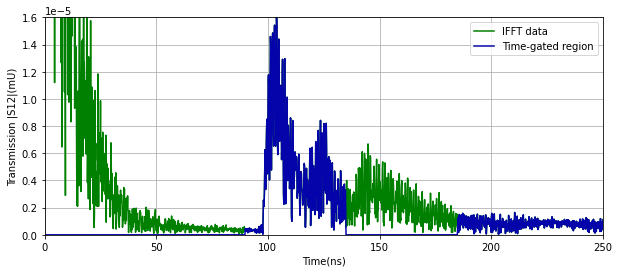

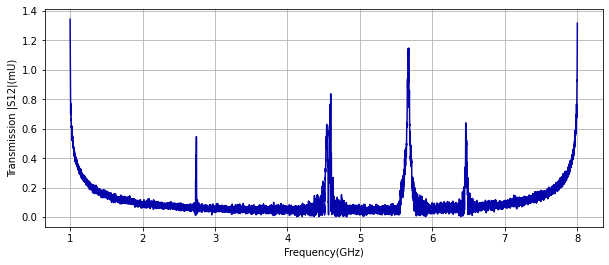

In [18]:
time_gated_FD_list_4K_1 = []
for i, ifft_data in enumerate(ifft_list_4K):
    if i == 3:
        plot_fig = True
    else:
        plot_fig = False
    _, nor_cmpl_filtered, t_span, ift_data, org_ift_data = Filter_S21_signals(   freq, 
                                                                                    ifft_data, 
                                                                                    t_reso,   
                                                                                    N_pts = N_pts,  
                                                                                    filter_noise = True,
                                                                                    filter_peaks = True,
                                                                                    filter_picking = False, 
                                                                                    filter_stop = False,
                                                                                    t_noise=[90], expand_noise = 0.1,
                                                                                    t_peaks=[ 150, 170], expand_peaks = 15,
                                                                                    t_picked = [0], expand_picked = 20,
                                                                                    t_stop = 500,
                                                                                    xmax=250, ymax=1600e-8, ymax_fdom = 3e-5, manual_scale= False,
                                                                                    savefig = False,
                                                                                    plot_filtering = plot_fig)

    time_gated_FD_list_4K_1.append(nor_cmpl_filtered)

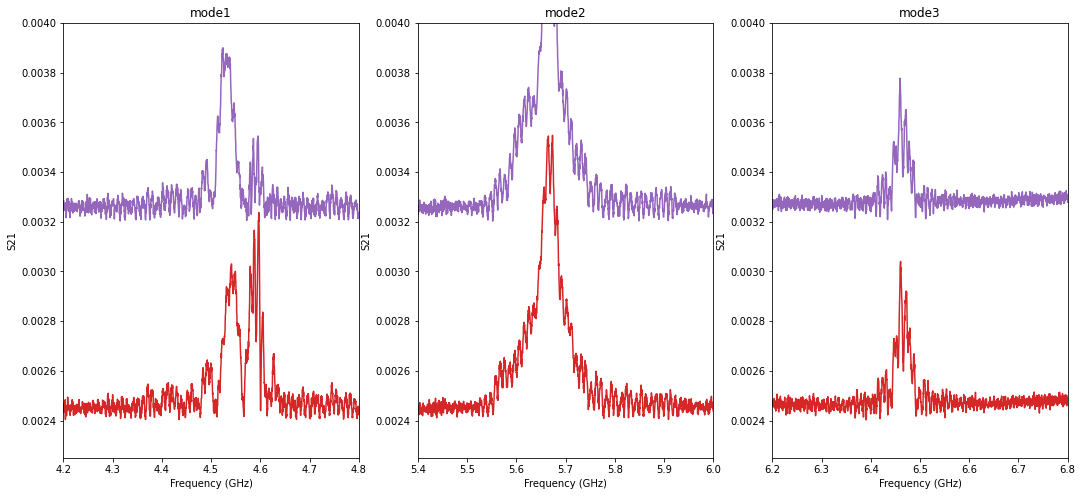

In [19]:
fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
for i, time_gated_data in enumerate(time_gated_FD_list_4K_1):
    ax1.plot(freq/1e9, np.abs(time_gated_data)+ i*8e-4)
    ax2.plot(freq/1e9, np.abs(time_gated_data)+ i*8e-4)
    ax3.plot(freq/1e9, np.abs(time_gated_data)+ i*8e-4)

ax1.set_xlim(4.2, 4.8)
ax2.set_xlim(5.4, 6)
ax3.set_xlim(6.2, 6.8)

for ax, mode in zip([ax1, ax2, ax3], ['mode1', 'mode2', 'mode3']):
    ax.set_xlabel('Frequency (GHz)')
    ax.set_ylabel('S21')
    ax.set_title(mode)
    ax.set_ylim(0.00225,0.004)


# Set plt size 
plt.rcParams['figure.figsize'] = [10, 8]

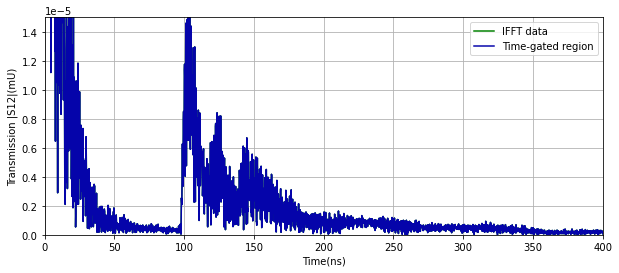

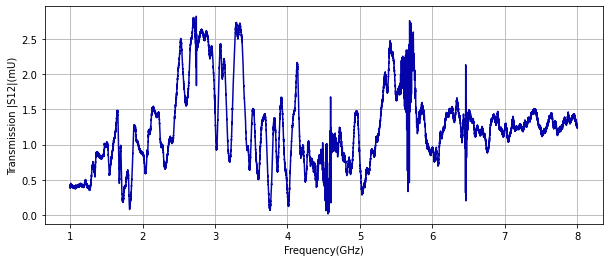

In [20]:
time_gated_FD_list_4K_2 = []
for i, ifft_data in enumerate(ifft_list_4K):
    if i == 3:
        plot_fig = True
    else:
        plot_fig = False
    _, nor_cmpl_filtered, t_span, ift_data, org_ift_data = Filter_S21_signals(   freq, 
                                                                                    ifft_data, 
                                                                                    t_reso,   
                                                                                    N_pts = N_pts,  
                                                                                    filter_noise = False,
                                                                                    filter_peaks = False,
                                                                                    filter_picking = False, 
                                                                                    filter_stop = False,
                                                                                    t_noise=[115], expand_noise = 0.1,
                                                                                    t_peaks=[ 100], expand_peaks = 10,
                                                                                    t_picked = [0], expand_picked = 20,
                                                                                    t_stop = 500,
                                                                                    xmax=400, ymax=1500e-8, ymax_fdom = 3e-5, manual_scale= False,
                                                                                    savefig = False,
                                                                                    plot_filtering = plot_fig)

    time_gated_FD_list_4K_2.append(nor_cmpl_filtered)

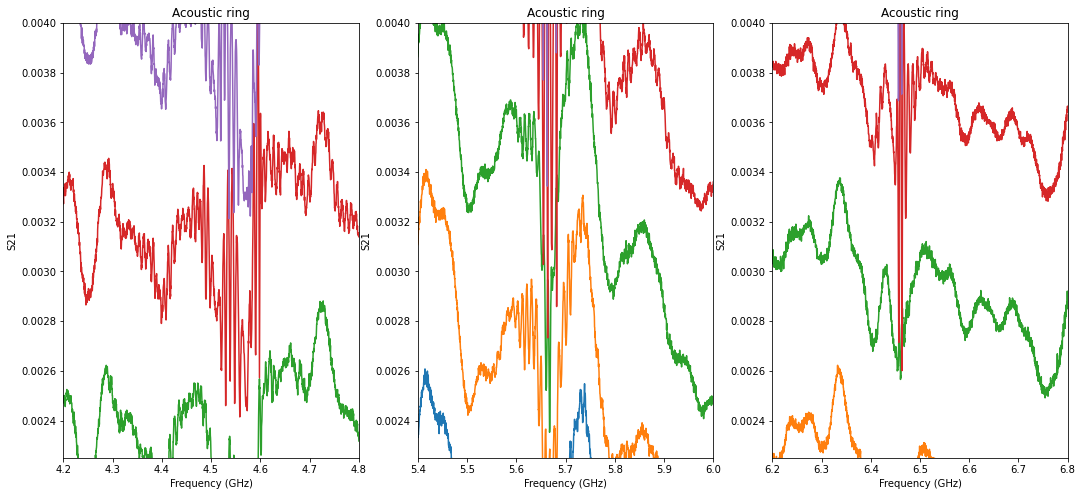

In [21]:
fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
for i, time_gated_data in enumerate(time_gated_FD_list_4K_2):
    ax1.plot(freq/1e9, np.abs(time_gated_data)+ i*8e-4)
    ax2.plot(freq/1e9, np.abs(time_gated_data)+ i*8e-4)
    ax3.plot(freq/1e9, np.abs(time_gated_data)+ i*8e-4)

ax1.set_xlim(4.2, 4.8)
ax2.set_xlim(5.4, 6)
ax3.set_xlim(6.2, 6.8)

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Frequency (GHz)')
    ax.set_ylabel('S21')
    ax.set_title('Acoustic ring')
    ax.set_ylim(0.00225,0.004)

# Set plt size 
plt.rcParams['figure.figsize'] = [10, 8]

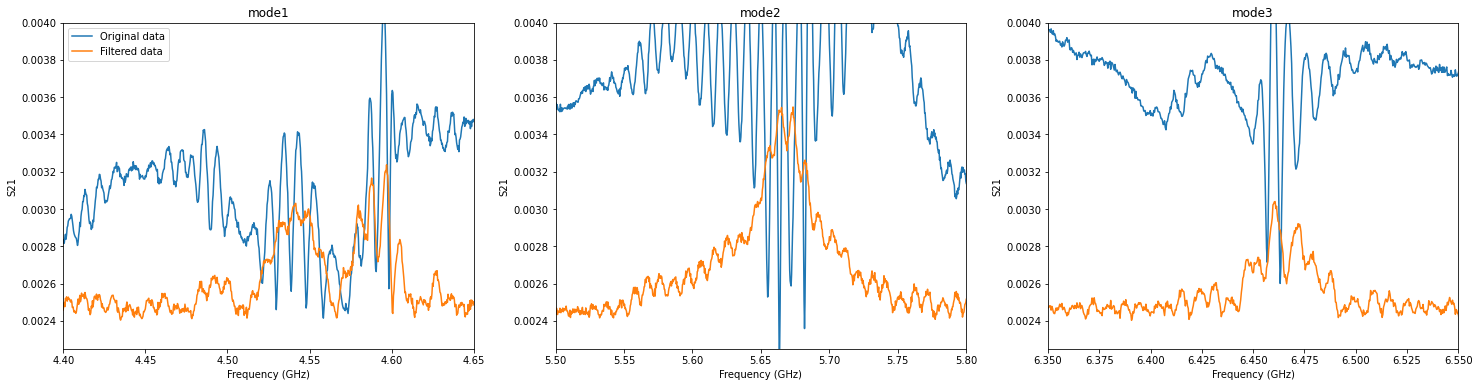

In [22]:
fig = plt.figure(figsize=(25, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

index = range(len(time_gated_FD_list_4K_2))
for i, time_gated_data_2, time_gated_data_1 in zip(index, time_gated_FD_list_4K_1, time_gated_FD_list_4K_2):
    if i == 3:
        ax1.plot(freq/1e9, np.abs(time_gated_data_1)+ i*8e-4, label = 'Original data')
        ax2.plot(freq/1e9, np.abs(time_gated_data_1)+ i*8e-4 - 0.0005)
        ax3.plot(freq/1e9, np.abs(time_gated_data_1)+ i*8e-4 )
        
        ax1.plot(freq/1e9, np.abs(time_gated_data_2)+ i*8e-4, label = 'Filtered data')
        ax2.plot(freq/1e9, np.abs(time_gated_data_2)+ i*8e-4)
        ax3.plot(freq/1e9, np.abs(time_gated_data_2)+ i*8e-4)

        S11_org = np.abs(time_gated_data_1)
        S11_fil = np.abs(time_gated_data_2)
    else:
        continue
ax1.set_xlim(4.4, 4.65)
ax2.set_xlim(5.5, 5.8)
ax3.set_xlim(6.35, 6.55)

for ax, mode in zip([ax1, ax2, ax3], ['mode1', 'mode2', 'mode3']):
    ax.set_xlabel('Frequency (GHz)')
    ax.set_ylabel('S21')
    ax.set_title(mode)
    ax.set_ylim(0.00225,0.004)

    if ax == ax1:
        ax.legend()



In [23]:
# Group velocity calculation
v_Ac = 650e3/100
L_ring = np.pi*100 + 50
L_wg = 589
print('acoustic velocity = ', v_Ac, 'm/s' )
print('Ring length= ', np.pi*100 + 50, 'um')
print('through waveguide length= ', 589, 'um') 

print('arrivial time = ', L_wg/v_Ac*1e3, 'ns')
print('Ring time = ', L_ring/v_Ac*1e3, 'ns')

acoustic velocity =  6500.0 m/s
Ring length=  364.1592653589793 um
through waveguide length=  589 um
arrivial time =  90.61538461538461 ns
Ring time =  56.0245023629199 ns


(4.0, 5.0)

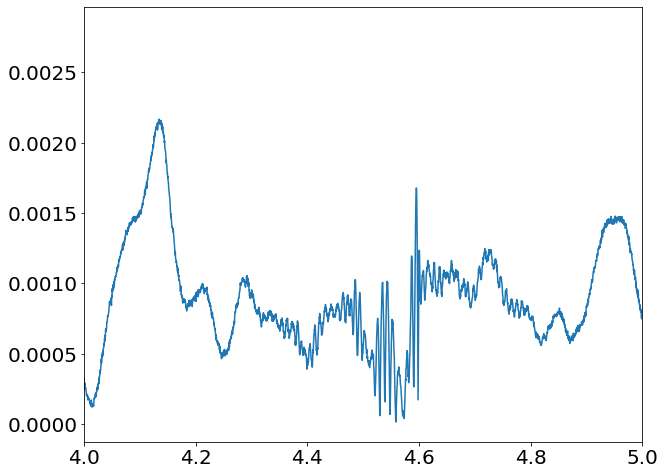

In [215]:
# Calculate the acoustic Q factor.
plt.plot(freq/1e9, S11_org, label = 'Original data')
#plt.plot(freq/1e9, S11_fil, label = 'Filtered data')

plt.xlim(4, 5)

10072 [10100]
[ 0.00090266  0.00383693 -0.16511293  0.03647481]
Gamma=  3.836932028593425 MHz
Q= 1180.6568284871814
cen_freq= 4.5301


/var/folders/gc/3xnjdbj16yqcqzk4qm53z0mh0000gn/T/ipykernel_18246/1128383121.py:9: RuntimeWarning: invalid value encountered in sqrt
  start = np.where( ((freq/1e9)**2 - start_freq**2)**0.5 < 0.1 )
/var/folders/gc/3xnjdbj16yqcqzk4qm53z0mh0000gn/T/ipykernel_18246/1128383121.py:10: RuntimeWarning: invalid value encountered in sqrt
  end = np.where(((freq/1e9)**2 - end_freq**2)**0.5 < 0.05 )


(4.45, 4.65, 0.0, 0.002)

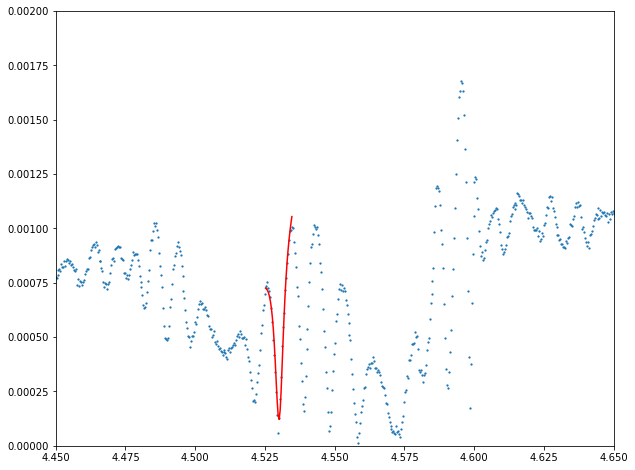

In [25]:
def lorentzian_inv( x, x0, a, gam ):
    return a - (a * (gam/2)**2 / ( (gam/2)**2 + ( x - x0 )**2) )

start_freq = 4.525 #GHz
end_freq = 4.535 #GHz
cen_freq = 4.5301 #GHz

#Find the start of the index(returns a list)
start = np.where( ((freq/1e9)**2 - start_freq**2)**0.5 < 0.1 ) 
end = np.where(((freq/1e9)**2 - end_freq**2)**0.5 < 0.05 )
print(start[0][0], end[0])

#Load x and y data
x_data = freq[start[0][0]:end[0][0]]/1e9
y_data = S11_org[start[0][0]:end[0][0]]
fix_x_cen = cen_freq 

popt_fit, pcov_fit = curve_fit(lambda t, amp, gam, y_off, A: 
                         lorentzian_inv( t, fix_x_cen, amp, gam ) + y_off + t*A,
                         x_data, 
                         y_data, 
                         p0=(0.001, 0.0005, 0.0019, 0), 
                         maxfev=5000,
                         bounds=((0,  0, -np.inf, -np.inf),(np.inf, np.inf, np.inf, np.inf))
                        )

amp, gam, y_off, A = popt_fit
print(popt_fit)
print('Gamma= ', gam*1e3, 'MHz')
print('Q=', fix_x_cen/gam)
print('cen_freq=', fix_x_cen)

fig = plt.figure()
ax = plt.subplot()

ax.scatter(freq/1e9, S11_org, s = 1.5)
ax.plot(x_data, lorentzian_inv( x_data, fix_x_cen, amp, gam ) + y_off + x_data*A, c='red')

x1,x2,y1,y2 = ax.axis()
ax.axis((4.45, 4.65, 0.0 ,0.002))

10096 [10124]
[ 0.0009807   0.00393284  0.02244641 -0.00490418]
Gamma=  3.932843604043039 MHz
Q= 1153.9996137487733


/var/folders/gc/3xnjdbj16yqcqzk4qm53z0mh0000gn/T/ipykernel_18246/3769896743.py:10: RuntimeWarning: invalid value encountered in sqrt
  start = np.where( ((freq/1e9)**2 - start_freq**2)**0.5 < 0.1 )
/var/folders/gc/3xnjdbj16yqcqzk4qm53z0mh0000gn/T/ipykernel_18246/3769896743.py:11: RuntimeWarning: invalid value encountered in sqrt
  end = np.where(((freq/1e9)**2 - end_freq**2)**0.5 < 0.05 )


(4.45, 4.65, 0.0, 0.002)

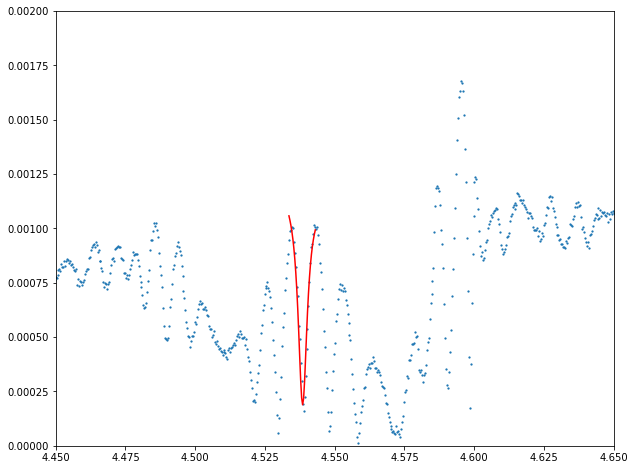

In [26]:
def lorentzian_inv( x, x0, a, gam ):
    return a - (a * (gam/2)**2 / ( (gam/2)**2 + ( x - x0 )**2) )

shift = 0.00840
start_freq = 4.525 + shift #GHz
end_freq = 4.535 + shift #GHz
cen_freq = 4.5301 + shift #GHz

#Find the start of the index(returns a list)
start = np.where( ((freq/1e9)**2 - start_freq**2)**0.5 < 0.1 ) 
end = np.where(((freq/1e9)**2 - end_freq**2)**0.5 < 0.05 )
print(start[0][0], end[0])

#Load x and y data
x_data = freq[start[0][0]:end[0][0]]/1e9
y_data = S11_org[start[0][0]:end[0][0]]
fix_x_cen = cen_freq 

popt_fit, pcov_fit = curve_fit(lambda t, amp, gam, y_off, A: 
                         lorentzian_inv( t, fix_x_cen, amp, gam ) + y_off + t*A,
                         x_data, 
                         y_data, 
                         p0=(0.001, 0.0005, 0.0019, 0), 
                         maxfev=5000,
                         bounds=((0,  0, -np.inf, -np.inf),(np.inf, np.inf, np.inf, np.inf))
                        )

amp, gam, y_off, A = popt_fit
print(popt_fit)
print('Gamma= ', gam*1e3, 'MHz')
print('Q=', fix_x_cen/gam)

fig = plt.figure()
ax = plt.subplot()

ax.scatter(freq/1e9, S11_org, s = 1.5)
ax.plot(x_data, lorentzian_inv( x_data, fix_x_cen, amp, gam ) + y_off + x_data*A, c='red')


x1,x2,y1,y2 = ax.axis()
ax.axis((4.45, 4.65, 0.0 ,0.002))

10120 [10151 10152]
[ 0.00091277  0.00386172  0.09525965 -0.02092652]
Gamma=  3.8617170121774067 MHz
Q= 1177.740364106996


(4.45, 4.65, 0.0, 0.002)

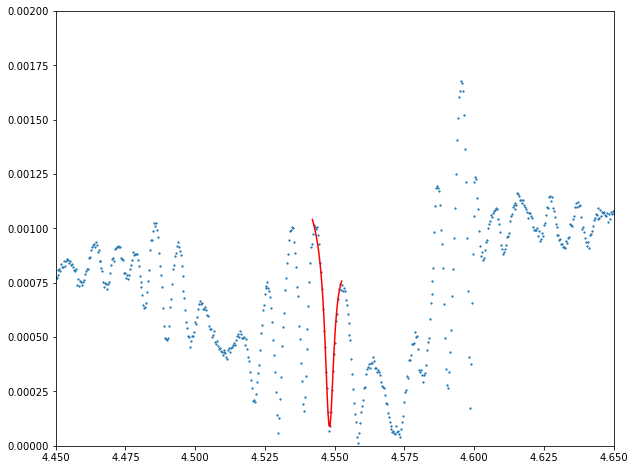

In [36]:
def lorentzian_inv( x, x0, a, gam ):
    return a - (a * (gam/2)**2 / ( (gam/2)**2 + ( x - x0 )**2) )

shift = 0.009*2
start_freq = 4.525 + shift #GHz
end_freq = 4.535 + shift #GHz
cen_freq = 4.5301 + shift #GHz

#Find the start of the index(returns a list)
start = np.where( (abs((freq/1e9)**2 - start_freq**2))**0.5 < 0.1 ) 
end = np.where((abs((freq/1e9)**2 - end_freq**2))**0.5 < 0.05 )
print(start[0][0], end[0])

#Load x and y data
x_data = freq[start[0][0]:end[0][0]]/1e9
y_data = S11_org[start[0][0]:end[0][0]]
fix_x_cen = cen_freq 

popt_fit, pcov_fit = curve_fit(lambda t, amp, gam, y_off, A: 
                         lorentzian_inv( t, fix_x_cen, amp, gam ) + y_off + t*A,
                         x_data, 
                         y_data, 
                         p0=(0.001, 0.0005, 0.0019, 0), 
                         maxfev=5000,
                         bounds=((0,  0, -np.inf, -np.inf),(np.inf, np.inf, np.inf, np.inf))
                        )

amp, gam, y_off, A = popt_fit
print(popt_fit)
print('Gamma= ', gam*1e3, 'MHz')
print('Q=', fix_x_cen/gam)

fig = plt.figure()
ax = plt.subplot()

ax.scatter(freq/1e9, S11_org, s = 1.5)
ax.plot(x_data, lorentzian_inv( x_data, fix_x_cen, amp, gam ) + y_off + x_data*A, c='red')


x1,x2,y1,y2 = ax.axis()
ax.axis((4.45, 4.65, 0.0 ,0.002))

In [144]:
def fit_mechanical_Q(span, cen_freq, freq, S11_org ):
    #Find the start of the index(returns a list)
    start = np.where( (abs((freq/1e9)**2 - (cen_freq-span)**2))**0.5 < 0.1 ) 
    end = np.where((abs((freq/1e9)**2 - (cen_freq+span)**2))**0.5 < 0.05 )
    print(start[0][0], end[0])

    #Load x and y data
    x_data = freq[start[0][0]:end[0][0]]/1e9
    y_data = S11_org[start[0][0]:end[0][0]]
    fix_x_cen = cen_freq 

    popt_fit, pcov_fit = curve_fit(lambda t, amp, gam, y_off, A: 
                            lorentzian_inv( t, fix_x_cen, amp, gam ) + y_off + t*A,
                            x_data, 
                            y_data, 
                            p0=(0.001, 0.0005, 0.0019, 0), 
                            maxfev=5000,
                            bounds=((0,  0, -np.inf, -np.inf),(np.inf, np.inf, np.inf, np.inf))
                            )

    amp, gam, y_off, A = popt_fit
    Q = fix_x_cen/gam
    print(popt_fit)
    print('Gamma= ', gam*1e3, 'MHz')
    print('Q=', Q)
    
    return amp, gam, y_off, A, x_data, Q

Mode 1 Quality factor.

10043 [10074 10075]
[ 0.00053149  0.0046043  -0.10795237  0.02392161]
Gamma=  4.604301106992937 MHz
Q= 981.9296989793797
10069 [10100 10101]
[ 0.00087844  0.00362681 -0.17601781  0.03888047]
Gamma=  3.6268058247142663 MHz
Q= 1249.0605284491344
10095 [10126]
[ 0.00096626  0.00389109 -0.07744581  0.01710497]
Gamma=  3.8910924017190283 MHz
Q= 1166.5361629537997
10120 [10151 10152]
[ 0.00091277  0.00386172  0.09525965 -0.02092652]
Gamma=  3.8617170121774067 MHz
Q= 1177.740364106996
10148 [10179]
[ 0.00053883  0.00434056  0.20259135 -0.04443396]
Gamma=  4.340556527764221 MHz
Q= 1050.0266430921538


(4.45, 4.65, 0.0, 0.002)

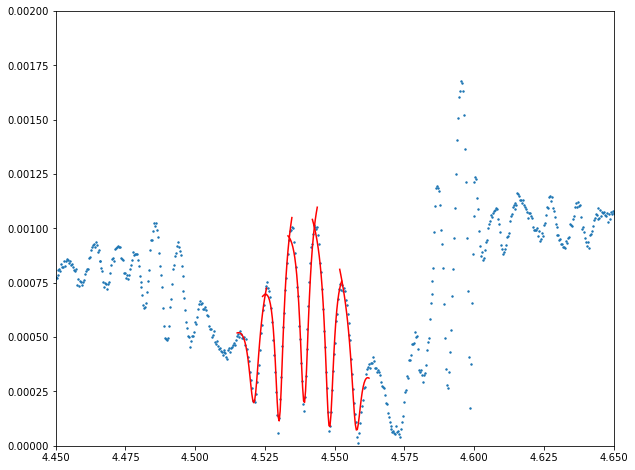

In [146]:
fig = plt.figure()
ax = plt.subplot()

# Define the parameters as a dictionary
parameters = {
    'freq': freq,
    'S11_org': S11_org,
    'span': 0.005
}

# Define the shifts
shifts = [-0.009, 0.009*0, 0.009*1, 0.009*2, 0.0092*3]
Quality_factor_M1 = []
for shift in shifts:
    parameters['cen_freq'] = 4.5301 + shift  # GHz
    amp, gam, y_off, A, x_data, Q = fit_mechanical_Q(**parameters)
    Quality_factor_M1.append(Q)
    ax.plot(x_data, lorentzian_inv(x_data, parameters['cen_freq'], amp, gam) + y_off + x_data*A, c='red')

ax.scatter(freq/1e9, S11_org, s=2)
x1, x2, y1, y2 = ax.axis()
ax.axis((4.45, 4.65, 0.0, 0.002))

Mode 2 Quality factor

13198 [13228 13229]
[ 0.00103297  0.00566862 -0.0422485   0.00777398]
Gamma=  5.668617487461329 MHz
Q= 992.3054452769466
13227 [13257]
[ 0.00119923  0.00601692 -0.03967692  0.00729752]
Gamma=  6.016923598204792 MHz
Q= 936.5251042378629
13255 [13286]
[ 0.0014411   0.00554373  0.07211647 -0.01256459]
Gamma=  5.54373458766845 MHz
Q= 1018.2666415085611
13284 [13314]
[ 0.0021073   0.00502095 -0.06322318  0.0112897 ]
Gamma=  5.020947503076235 MHz
Q= 1126.2814432007688
13309 [13340]
[ 0.00207338  0.0028598  -0.17543243  0.03104396]
Gamma=  2.859802458795908 MHz
Q= 1980.5563781439546
13334 [13364 13365]
[ 0.00344076  0.01034761 -0.2192462   0.03878566]
Gamma=  10.34760667106985 MHz
Q= 548.2040611245523
13360 [13390]
[ 0.00219906  0.00291921 -0.24609038  0.04340585]
Gamma=  2.919205975911126 MHz
Q= 1946.282669631317
13385 [13416]
[ 0.00154684  0.00673525  0.19373152 -0.03379019]
Gamma=  6.735254244696609 MHz
Q= 844.8975782140404


(5.5, 5.8, 0.0, 0.004)

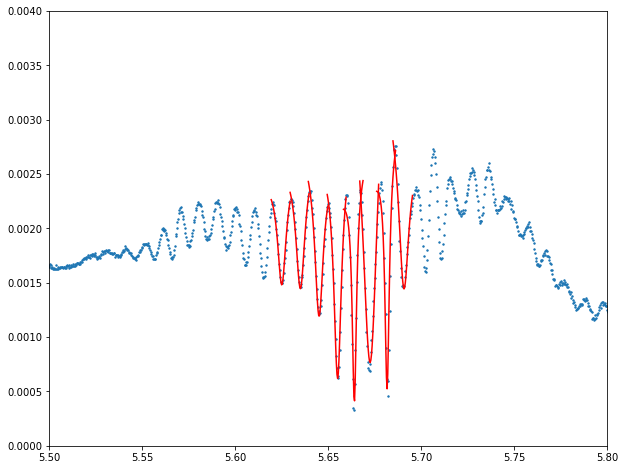

In [192]:
fig = plt.figure()
ax = plt.subplot()

# Define the parameters as a dictionary
parameters = {
    'freq': freq,
    'S11_org': S11_org,
    'span': 0.005,
    'cen_freq': 5.625
}

# Define the shifts
x = np.array(range(10))
shifts = [0, 0.01, 0.01, 0.01, 0.009, 0.0086, 0.009, 0.009]
Quality_factor_M2 = []

for shift in shifts:
    parameters['cen_freq'] = parameters['cen_freq'] + shift  # GHz
    amp, gam, y_off, A, x_data, Q = fit_mechanical_Q(**parameters)
    Quality_factor_M2.append(Q)
    ax.plot(x_data, lorentzian_inv(x_data, parameters['cen_freq'], amp, gam) + y_off + x_data*A, c='red')

ax.scatter(freq/1e9, S11_org, s=2)
x1, x2, y1, y2 = ax.axis()
ax.axis((5.50, 5.80, 0.0, 0.004))

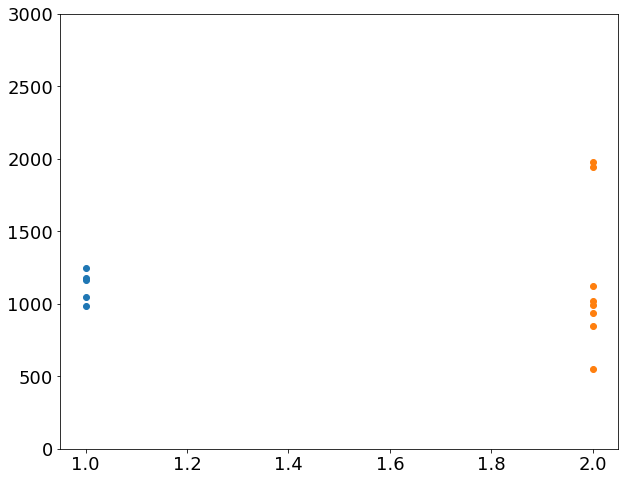

In [214]:
fig = plt.figure()
ax = plt.subplot()
x1 = np.ones(len(Quality_factor_M1))*1
x2 = np.ones(len(Quality_factor_M2))*2
ax.plot(x1, Quality_factor_M1, 'o', label = 'Mode 1' )
ax.plot(x2, Quality_factor_M2, 'o',  label = 'Mode 2' )
ax.set_ylim(0, 3000)
#set the font size of the figure
plt.rcParams.update({'font.size': 20})

In [58]:
Q_List = [981, 1249, 1160, 1177, 1050]
np.array(range(0,10))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Quality factor calculation and conversion

 Using the formula in paper to calculate the propagation loss

The paper is referred [here](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.15.014039)

The formula is

$$
\alpha = \frac{2\pi f}{Q_iv_g}
$$

- **Intrinsic Q and loaded Q:**
$$
\alpha \text{ [dB/cm]}=-10\log_{10}e^{\alpha(cm^{-1})}=4.34 \alpha(cm^{-1})\text{ [dB/cm]}
$$

$$
Q_i=\frac{2Q_l}{1+\sqrt{T_0}}
$$

$$
FSR = \frac{V_g}{L}

In [206]:
Q_al = 1250
FSR = 0.01e9 #Hz
L_ring = (np.pi*100 + 50)*1e-6 #m
T = 0

v_g = FSR * L_ring #m/s

omega_a = 5.5*1e9*2*np.pi #rad Hz

Q_ai = 2*Q_al/(1+np.sqrt(T)) 

alpha = omega_a/(Q_ai*v_g)*1e-3 #1/mm

print('Q_ai=', Q_ai)
print('alpha=', -10*np.log10(np.exp(alpha)), 'dB/mm')

Q_ai= 2500.0
alpha= -16.48524842828381 dB/mm


# Short remarks on the acoustic ring data so far.
1. The radio-frequency reflection spectrum (S11) clearly shows prominent at 4.5 GHz (M1), 5.5 GHz (M2) and 6.45 GHz (M3). Simulation needs to be performed to identify the modes.
2. The transmission spectrum (S21) shows resonant feature at all three modes. This is good because without filtering the data we already see the resonant feature.
    The quality factors extracted from the transmission specturm for M1 are (1180, 1153, 1111), which is close to critical coupling region.  **More fittings are needed on M2 and M3**.
3. Some important numbers we can extract from the data.
    - Acoustic group velocity of the propagating mode ~ 6000m/s (calculated from the time delay between the two peaks in the time domain data)
    - Acoustic FSR estimated from the unprocessed S21 data ~ 8.6 MHz. 
\begin{equation}
    FSR = \frac{v_g}{L_{ring}}
\end{equation}
    - from calculation above the ring diameter is 100 um, V_g = 6000 m/s.

4. From COMSOL simulation. The group velocity at 4.55 GHz's fundamental mode (at ZnO area).
$$d\omega/dk = \frac{4.79-4.55 \text{ (GHz)}}{1.5-1 \text{ (1/$\mu$m)}} = 480 \text{ m/s}$$
The calculation result tells us that this is likly not the mode that is propagating within the ring resonator. The mode has a energy concentrating at the ZnO area but not at the Si layer. 

In [2]:
(4.79-4.55)/ 0.5 *1e3

480.00000000000045

In [235]:
4.54/0.004
L_ring = 100*np.pi + 50 #um
L_wg = 589 #um

t_1 = 100  #ns
t_2 = 125 #ns
t_3 = 150 #ns

M1_aco = L_ring/t_1*1e3 #m/s
M2_aco = L_ring/t_2*1e3 #m/s
M3_aco = L_ring/t_3*1e3 #m/s

print('M1 acoustic velocity = ', M1_aco, 'm/s' )
print('M2 acoustic velocity = ', M2_aco, 'm/s' )
print('M3 acoustic velocity = ', M3_aco, 'm/s' )

print('Ring FSR =', 6000/(L_ring*1e-6) / 1e6 , 'MHz')
print('WG Fsr = ', M1_aco/(L_wg*1e-6) /1e6 , 'MHz')

M1 acoustic velocity =  3641.592653589793 m/s
M2 acoustic velocity =  2913.2741228718346 m/s
M3 acoustic velocity =  2427.728435726529 m/s
Ring FSR = 16.476307403809557 MHz
WG Fsr =  6.182670040050582 MHz


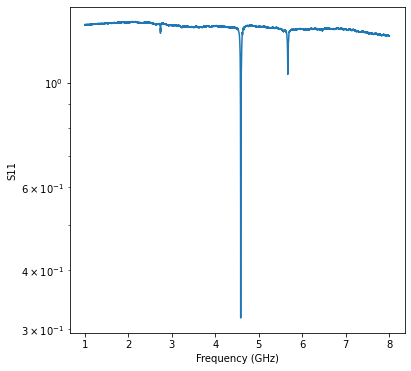

In [113]:
# Set plt size 
plt.rcParams['figure.figsize'] = [6, 6]
for i, s11 in enumerate(S11_list_4K):
    if i == 3:
        plt.plot(freq/1e9, np.abs(s11)+0.1*i)
    else:
        continue

plt.xlabel('Frequency (GHz)')
plt.ylabel('S11')
plt.yscale('log')